<a href="https://colab.research.google.com/github/jacksone1/DataSci/blob/main/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [2]:
#Load the data from Mr. Arredondo's github page to a pandas dataframe.
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
#Get the difference between theoretical and expiremental values element wise
diff_TminusE = cs_data.theo - cs_data.exp
#Add a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
#identifies all the different amino acids in our data set
#and stores that information, plus original info, in the variable aa_encode
aa_encode = pd.Categorical(cs_data['aa'])
#Replaces all the amino acid names with a number in the variable aa_idx
aa_idx = aa_encode.codes
#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
aa_coords = {"aa": aa_encode.categories}

In [3]:
#print a the begining and end of the raw data set, as a pandas dataframe
cs_data

,ID,aa,theo,exp,diff_TminusE,cat
0,1BM8,ILE,61.18,58.27,2.91,Non-Polar
1,1BM8,TYR,56.95,56.18,0.77,Polar
2,1BM8,SER,56.35,56.84,-0.49,Polar
3,1BM8,ALA,51.96,51.01,0.95,Special
4,1BM8,ARG,56.54,54.64,1.90,Charged
...,...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,-1.72,Charged
1772,1KS9,ARG,58.91,59.02,-0.11,Charged
1773,1KS9,LYS,59.49,58.92,0.57,Charged
1774,1KS9,GLU,59.48,58.36,1.12,Charged


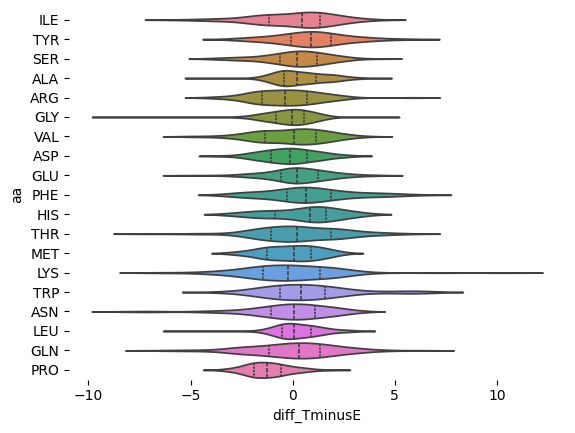

In [4]:
#visualize difference in chem shift values for all the amino acids
sns.violinplot(cs_data, x='diff_TminusE', y='aa', inner='quart',hue='aa')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

In [5]:
with pm.Model(coords=aa_coords) as cs_n_model:
    #Hyperpriors shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    #Priors for each amino acid
    #The μ priors 'talk' to one another through their hyperpriors
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #The Normal likelihood
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, n for normal
    idata_cs_n = pm.sample()

Output()

Output()

In [6]:
#The Student T likelihood requires a prior for the nu value, which the normal model doesn't have.
#The Student T mu prior requires a nu hyperprior for its nu value as well
with pm.Model(coords=aa_coords) as cs_t_model:
    #Hyperpriors shared across all amino acids
    μ_mu = pm.StudentT('μ_mu', mu = 0, sigma = 10, nu = 15)
    μ_sd = pm.HalfStudentT('μ_sd', sigma = 10, nu = 15)
    μ_ν = pm.Exponential('μ_ν', lam=1/30)

    #Priors for each amino acid
    #The μ priors 'talk' to one another through their hyperpriors
    μ = pm.StudentT('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  nu = μ_ν,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', sigma = 10,
                        nu = 15,
                        dims = "aa")
    ν = pm.Exponential('ν', lam=1/30, dims = "aa")

    #The Student T likelihood
    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  nu = ν[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_t = pm.sample()

Output()

Output()

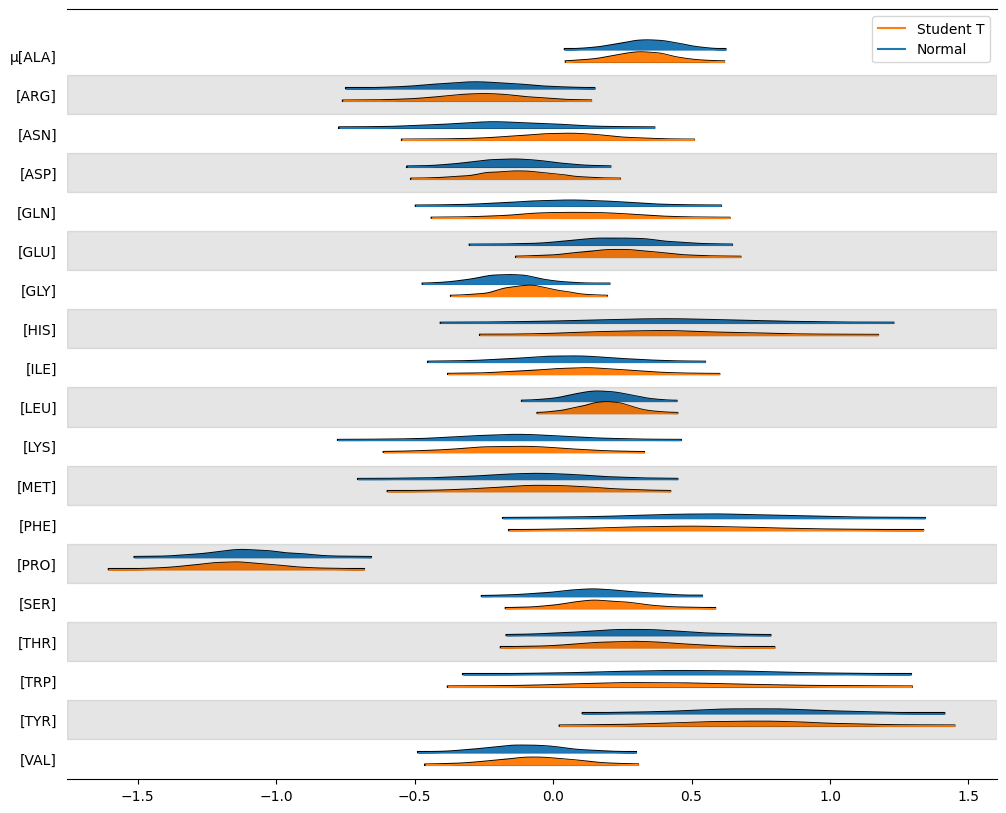

In [7]:
#plots a 99.7% hdi for the posteriors of both models on the same plot
axes = az.plot_forest([idata_cs_n, idata_cs_t], kind="ridgeplot",
                      model_names=['Normal', 'Student T'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

The shapes of the posteriors are very similar, but the t based model has means slightly closer to zero.

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

In [8]:
pm.sample_posterior_predictive(idata_cs_n, model=cs_n_model, extend_inferencedata=True)
pm.sample_posterior_predictive(idata_cs_t, model=cs_t_model, extend_inferencedata=True)

Output()

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

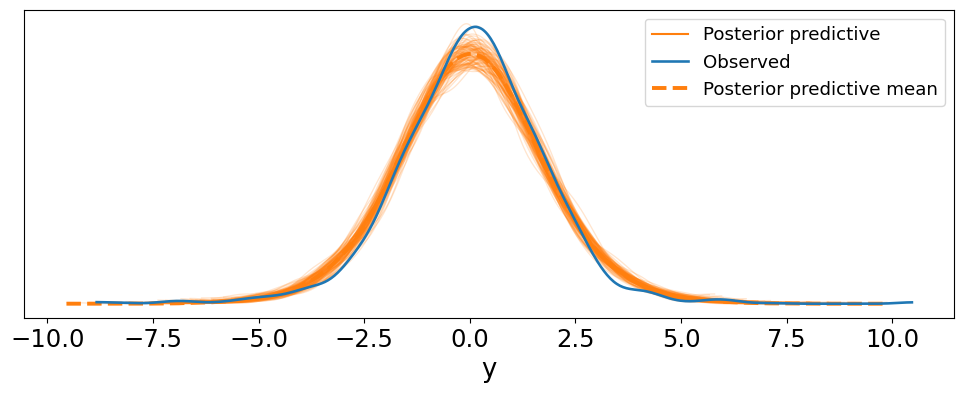

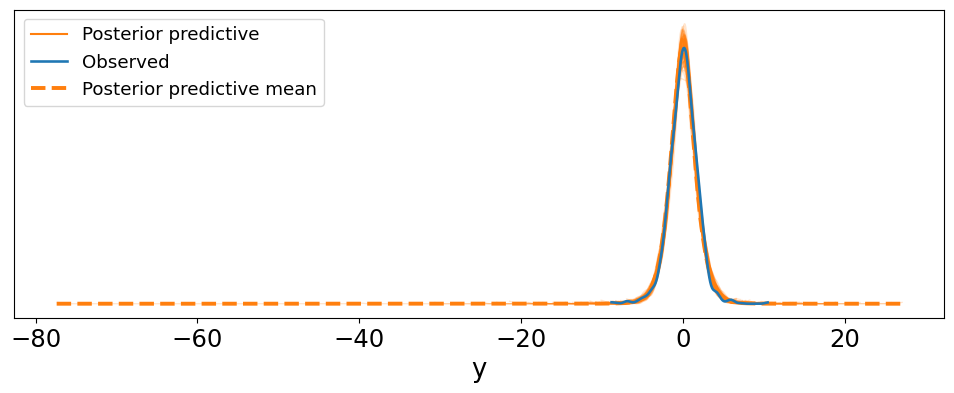

In [9]:
az.plot_ppc(idata_cs_n, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
az.plot_ppc(idata_cs_t, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

The t-based model seems to fit the data better, as the predictions and predictive mean appear to be much more closely aligned with the observed line than the normal model.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [10]:
#load the data from Mr. Arredondo's github page.
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'

#Turns the position column into a categorical variable
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

In [11]:
sccr_data

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


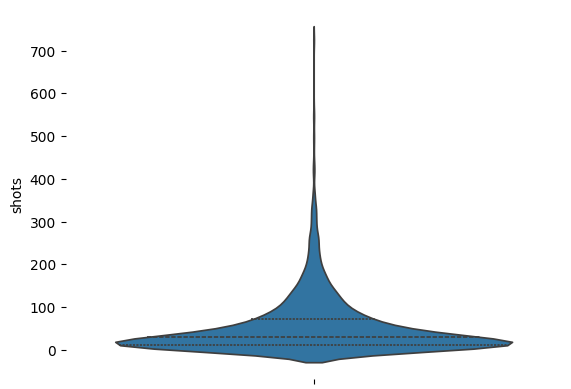

In [12]:
sns.violinplot(sccr_data.shots, inner='quart')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

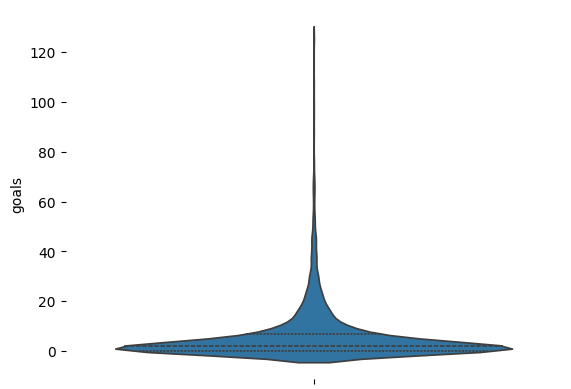

In [13]:
sns.violinplot(sccr_data.goals, inner='quart')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

In [14]:
with pm.Model(coords = sccr_coords) as sccr_model:
    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = 2/(2+20), nu = 55, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

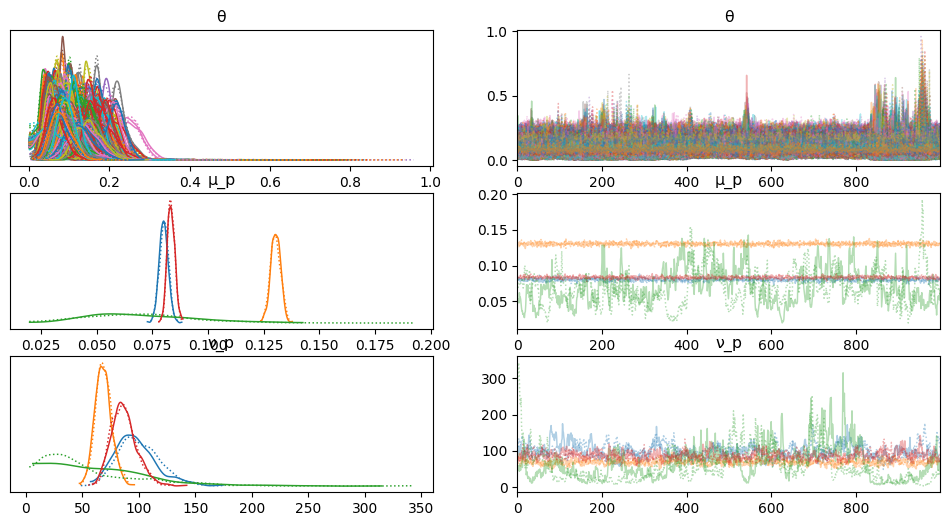

In [15]:
#Visualize markov chains
az.plot_trace(idata_sccr)

In [16]:
#Use arviZ to find the rhat values
az.rhat(idata_sccr)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.004 1.001 1.002 1.0 ... 1.001 1.001 1.003
    μ_p      (pos) float64 32B 1.003 1.001 1.007 1.0
    ν_p      (pos) float64 32B 1.008 1.004 1.045 0.9997

This response was written based on the first instance of the above cells running together, so the numbers included are no longer reflected in the output above due to having to re-run the model in subsequent sessions.

The non-hierarchical model seems to have similar trouble with the goalkeeper position, as the r hat value for the goalkeepers for mu_p is 1.046, which is quite high, and the r hat value for nu_p is even worse at 1.163. This can be seen in the green curves on the respective markov chain visualizations. The defender r hat value for nu_p for the hierarchical model for me was 1.017, whereas the corresponding non-hierarchical value is actually less than that at 1.005, implying it handled the defender position better. I believe the defender position is represented by the blue line in the markov chain visual, though it is difficult to visually distinguish the difference in efficacy between the two models by comparing the blue lines of each. The other r hat values for the non-hierarchical models seem to closely approximate or be slightly less than the corresponding values of the hierarchical model. The goalkeeper values give both models trouble in their predictions, though for the hierarchical model, the goalkeeper values also negatively affect the efficacy of predictions for other groups as a result of the interdependency.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

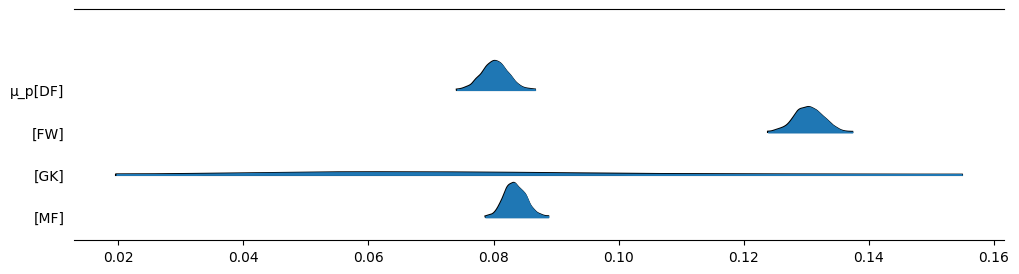

In [17]:
# plots a 99.8% HDI for the positions shooting percentage means
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

The non goalkeeper posteriors for this model seem to have a slightly higher variation but have approximately the same shapes and centers as those of the hierarchical model. The goalkeeper posterior exhibits the greatest change, as it has shifted in range from about .01-.15 in the hierarchical model to about .02-.16 in the non-hierarchical one. However, this is still a very small change, and this does not make that posterior more useful. The variation and HDI for the goalkeepers are still massive in comparison to those of the other positions. The models are very similar and neither is clearly more helpful than the other.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [53]:
#Get goalkeeper indices in sccr_data
gk_ind_list = list(sccr_data.query('position == "GK"').index)
print(gk_ind_list)

[6, 59, 62, 63, 66, 93, 96, 99, 100, 107, 108, 113, 123, 127, 132, 174, 192, 209, 213, 221, 228, 261, 280, 282, 292, 306, 312, 318, 323, 348, 419, 437, 521, 549, 551, 554, 566, 588, 598, 640, 649, 654, 667, 674, 679, 710, 717, 788, 810, 814, 845, 868, 892, 905, 906, 935, 987, 997, 1019, 1021, 1041, 1048, 1051, 1056, 1094, 1107, 1129, 1153, 1157, 1168, 1181, 1203, 1234, 1239, 1284, 1331, 1333, 1336, 1351, 1370, 1375, 1387, 1429, 1447, 1466, 1471, 1512, 1514, 1534, 1536, 1556, 1558, 1568, 1582, 1583, 1614, 1615, 1644, 1655, 1672, 1679, 1717, 1724, 1729, 1771, 1776, 1794, 1881, 1885, 1929, 1935, 1952, 1995, 1997, 2000, 2004, 2014, 2026, 2037, 2038, 2040, 2055, 2059, 2073, 2079, 2102, 2135, 2140, 2150, 2158, 2160, 2181, 2184, 2187, 2198, 2215, 2217, 2220, 2236, 2239, 2306, 2314, 2321, 2322, 2340, 2378, 2386, 2396, 2402, 2411, 2436, 2451, 2457, 2462, 2479, 2482, 2488, 2513, 2529, 2567, 2570, 2591, 2607, 2646, 2659]


In [56]:
#Create new versions of the position data with the goalkeepers (designated GK or 2) removed
#ngk is short for no goalkeeper

#Remake sccr_data without goalkeepers
#sccr_data_ngk = sccr_data.loc[sccr_data.position != "GK"]
sccr_data_ngk = sccr_data.drop(gk_ind_list, inplace = False)
print(sccr_data_ngk)

#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
sccr_data_ngk.position = sccr_data_ngk.position.cat.remove_unused_categories()
pos_idx_ngk = sccr_data_ngk.position.cat.codes.values
print(pos_idx_ngk)

#an array of the four strings that represent position
pos_codes_ngk = sccr_data_ngk.position.cat.categories
print(pos_codes_ngk)

#puts coords in a dict, so pymc can read them
sccr_coords_ngk = {"pos": pos_codes_ngk}
print(sccr_coords_ngk)

                  name position  goals  shots
0       Aaron Connolly       FW      5     59
1      Aaron Cresswell       DF      4     69
2           Aaron Hunt       MF      3     30
3         Aaron Lennon       MF      1      5
4     Aaron Leya Iseka       FW     10     76
...                ...      ...    ...    ...
2677    Óscar Mingueza       DF      2     12
2678       Óscar Plano       MF     12    124
2679   Óscar Rodríguez       MF     13    133
2680       Óscar Trejo       MF      1     20
2681       Ömer Toprak       DF      2     23

[2517 rows x 4 columns]
[1 0 2 ... 2 2 0]
Index(['DF', 'FW', 'MF'], dtype='object')
{'pos': Index(['DF', 'FW', 'MF'], dtype='object')}


In [57]:
with pm.Model(coords = sccr_coords_ngk) as sccr_model_ngk:
    # Hyper parameters
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)


    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu = μ_p[pos_idx_ngk], nu = ν_p[pos_idx_ngk])

    #This tells our model how many shots and goals each player has
    _ = pm.Binomial('gs',
                    n = sccr_data_ngk.shots.values, #shots for each player
                    p = θ, #guess of goals per shot
                    observed = sccr_data_ngk.goals.values) #goals per player

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_sccr_ngk = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([<Axes: >], dtype=object)

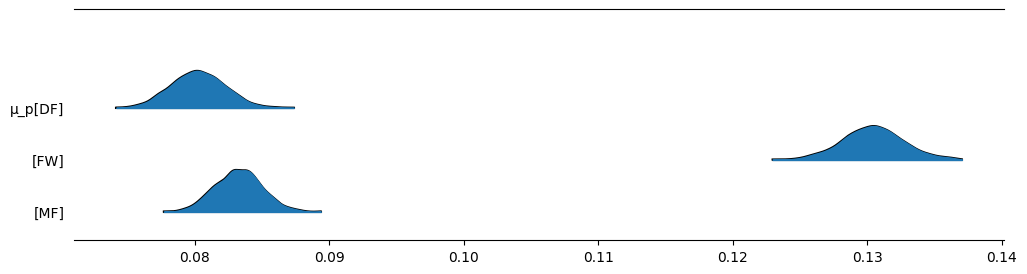

In [58]:
# plots a 99.8% HDI for the positions shooting percentage means
az.plot_forest(idata_sccr_ngk, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

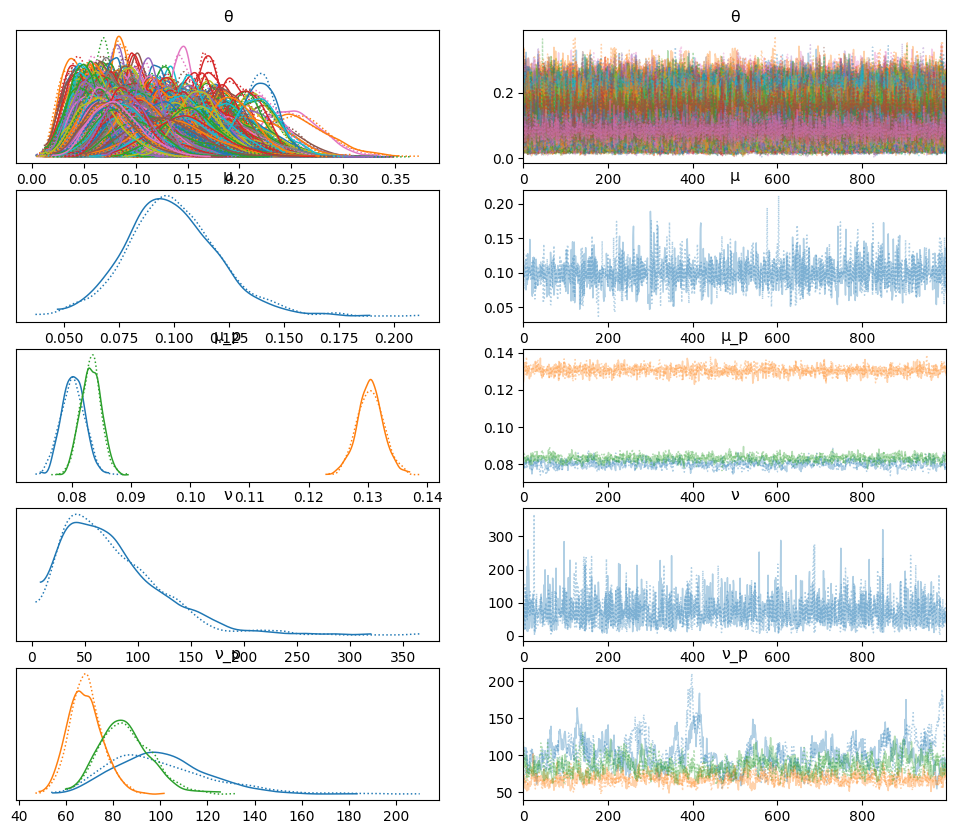

In [59]:
#Visualize markov chains
az.plot_trace(idata_sccr_ngk)

In [61]:
#Using arviZ to find the rhat values
az.rhat(idata_sccr_ngk)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 3)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 24B 'DF' 'FW' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.001 1.004 1.0 0.9998 ... 1.001 1.002 1.001
    μ        float64 8B 1.002
    μ_p      (pos) float64 24B 1.002 1.004 1.004
    ν        float64 8B 1.0
    ν_p      (pos) float64 24B 1.008 1.003 1.028

PYMC was able to process the dataset better without the goalkeepers in it, as it resulted in less unreasonable r hat values. With the exception of nu_p for the midfielders, the r hat values differ from 1 on the order of .001. The amplitudes of the curves tend to me more consistent and small with the same exception as previously mentioned. While the goalkeeper model had a nu_p r hat of 1.004 for midfielders, this model has a value 1.028 of the same context. While the model seems to now have more trouble predicting midfielders, this trouble is not nearly as bad as the 1.208 nu_p r hat value from the goalkeeper model for the goalkeepers. The model without goalkeepers appears to have less trouble overall with the data, but the midfielder predictions suffer. This model without goalkeepers seems to be a better choice for predicting goals for the remaining three values.